# 12 基于神经网络的图像分类

## 12.1 构建一个深度神经网络进行图像分类

之前的课程中我们学习了神经网络的基础知识，这节课我们来学习基于神经网络的图像分类。<br>
这个例子中，我们使用一个简单的数据集——Fashion MNIST数据集，这个数据集包含10个分类：T恤、裤子、鞋子等等。

### 12.1.1 准备用于训练的数据

在PyTorch的torchvision库中，包含很多数据集，其中也包括Fashion MNIST数据集，首先我们先导入相应的模块，并下载数据集。

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
#定义数据集下载的路径
data_folder = '/kaggle/working/data/FMNIST'
#下载数据集，并且指定train=True，并且指定只下载训练数据集
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
#将图片存储到变量tr_images中
tr_images = fmnist.data
#将图片的分类存储到变量tr_targets中
tr_targets = fmnist.targets

100%|██████████| 26421880/26421880 [00:00<00:00, 112141186.60it/s]


Extracting /kaggle/working/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4497380.02it/s]

Extracting /kaggle/working/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60073328.28it/s]


Extracting /kaggle/working/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25583266.58it/s]


Extracting /kaggle/working/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FMNIST/FashionMNIST/raw



打印数据集信息，这个数据集中，共有60000张图片，每张图片的尺寸是28*28像素。

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


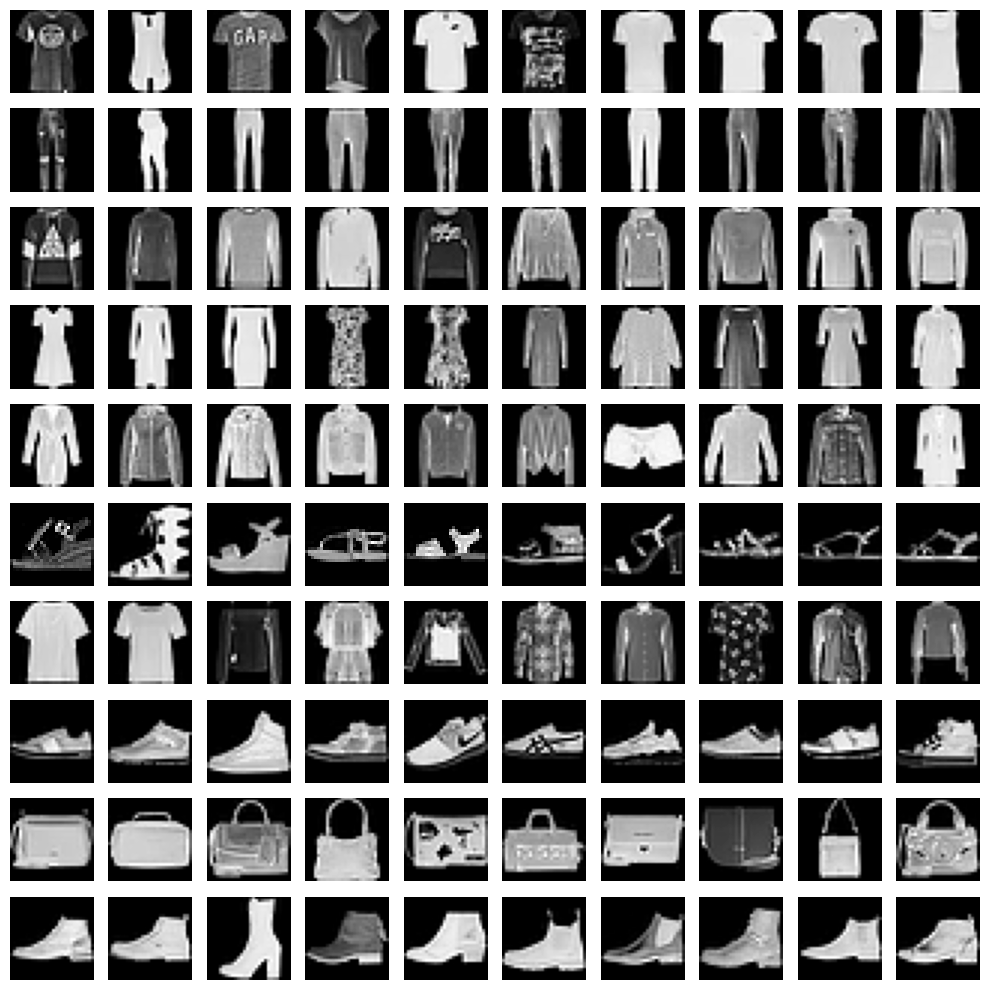

In [2]:
import matplotlib.pyplot as plt
import numpy as np

R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

### 12.1.2 训练神经网络模型

要训练神经网络模型，我们需要执行以下步骤：
1. 导入相应的库
2. 构建一个dataset对象，每次获取一个数据点
3. 将dataset对象传入数据加载器中
4. 定义神经网络模型，损失函数和优化器optimizer
5. 定义两个函数分别用于训练和验证数据
6. 定义函数用于计算模型的准确度
7. 训练并更新权重

#### 12.1.2.1 导入相应的库和fmnist数据集

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = '~/data/FMNIST' # This can be any directory you
# want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

100%|██████████| 26421880/26421880 [00:00<00:00, 115978375.44it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4358207.45it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61121751.92it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24125449.15it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



#### 12.1.2.2 定义一个dataset类来获取数据集，在这个类中需要定义__init__, __getitem__, __len__方法，供PyTorch调用，详情参考：11.10 数据集（Dataset）数据加载器（DataLoader）和批量尺寸（batch size）

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

请注意，在 __init__ 方法中，我们将输入转换为浮点数，并且将每张图像展平成 28*28 = 784 个数值（每个数值对应一个像素值），-1表示自动计算的维度，通常是样本数量。我们还在 __len__ 方法中指定了数据点的数量；在这里，它是 x 的长度。__getitem__ 方法包含了当我们请求第 ix 个数据点时应该返回什么的逻辑（ix 将是一个介于 0 和 __len__ 之间的整数）。

#### 12.1.2.3 创建一个函数来生成数据加载器DataLoader

In [5]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

#### 12.1.2.4 定义神经网络模型、损失函数和optimizer

In [6]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

这个模型是一个包含1000个神经元的隐藏层的神经网络模型。输出层有10个神经元，因为有10个可能的类别。此外，我们使用了分类交叉熵函数CrossEntropyLoss，因为对于每张图像的输出可以属于10个类别中的任何一个。最后，在这个练习中需要注意的关键点是，我们将学习率 lr 初始化为0.01，而不是默认的0.001，以观察模型在这个练习中的学习情况。

#### 12.1.2.5 定义一个函数用于训练模型

In [7]:
def train_batch(x, y, model, optimizer, loss_fn):
    """
    用于训练一个批次的函数
    :param x: 输入数据（一个批次）
    :param y: 真实标签（一个批次）
    :param model: 神经网络模型
    :param optimizer: 优化器
    :param loss_fn: 损失函数
    :return: 当前批次的损失值（标量）
    """
    # 设置模型为训练模式（启用 Dropout 等特性，适用于训练阶段）
    model.train()
    
    # 前向传播：将输入数据传入模型，得到预测值
    prediction = model(x)
    
    # 计算损失：根据预测值和真实标签计算损失值
    batch_loss = loss_fn(prediction, y)
    
    # 反向传播：根据前向传播计算的损失值，计算模型参数的梯度
    batch_loss.backward()
    
    # 参数更新：根据优化器和梯度更新模型的参数
    optimizer.step()
    
    # 清除梯度：为下一个批次的计算清空参数的梯度
    optimizer.zero_grad()
    
    # 返回当前批次的损失值（将张量转为标量）
    return batch_loss.item()

前面的代码在前向传播中将一批图像传递通过模型。它还计算了这批图像的损失值，然后通过反向传播传递权重并更新权重。最后，清空梯度的内存，以便它不会影响下一次传递中梯度的计算。<br>
现在我们已经完成了这些，我们可以通过在 `batch_loss` 上调用 `batch_loss.item()` 来提取损失值作为一个标量。

#### 12.1.2.6 定义一个函数来计算给定数据集的准确度

In [8]:
import torch

@torch.no_grad()  # 禁用梯度计算（节省内存，提高推理速度）
def accuracy(x, y, model):
    """
    计算模型在给定输入和标签上的准确率
    :param x: 输入数据（张量）
    :param y: 真实标签（张量）
    :param model: 神经网络模型
    :return: 每个样本预测是否正确的布尔列表
    """
    # 设置模型为评估模式（关闭 Dropout 和 BatchNorm 的训练特性）
    model.eval()
    
    # 前向传播：获取输入数据 x 的预测值
    prediction = model(x)
    
    # 找到每行中最大值的索引（对应类别）
    max_values, argmaxes = prediction.max(-1)
    
    # 判断预测结果 argmaxes 是否与真实标签 y 一致
    is_correct = argmaxes == y
    
    # 将结果从 GPU 移动到 CPU，并转换为 NumPy 数组，然后转为 Python 列表
    return is_correct.cpu().numpy().tolist()

在前面的代码中，我们通过提供 `@torch.no_grad()` 明确指出不需要计算梯度，并通过前向传播输入通过模型来计算预测值。接下来，我们调用 `prediction.max(-1)` 来识别每行对应的 `argmax` 索引。然后，我们通过 `argmaxes == y` 将我们的 `argmax` 值与真实值进行比较，以便检查每行是否被正确预测。最后，我们在将其设备绑定到 CPU 并转换为 NumPy 数组后，返回 `is_correct` 对象的列表。

#### 12.1.2.7 训练模型

0
1
2
3
4


/tmp/ipykernel_30/1090271826.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


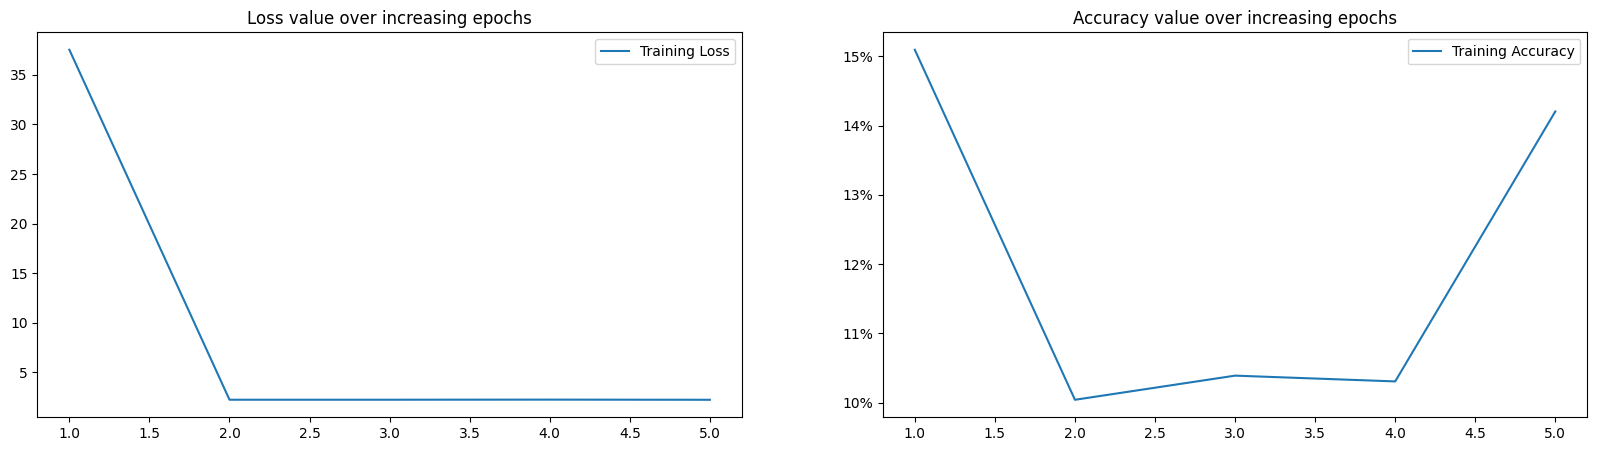

In [9]:
# 获取训练数据加载器
trn_dl = get_data()

# 初始化模型、损失函数和优化器
model, loss_fn, optimizer = get_model()

# 用于存储损失值和准确率的列表
losses, accuracies = [], []

# 开始训练循环，共训练 5 个 epoch
for epoch in range(5):
    print(epoch)  # 输出当前 epoch 编号
    
    # 存储每个 epoch 的损失值和准确率
    epoch_losses, epoch_accuracies = [], []
    
    # 训练阶段：计算每个批次的损失
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch  # 获取输入和标签
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # 训练一个批次
        epoch_losses.append(batch_loss)  # 记录当前批次损失值
    epoch_loss = np.array(epoch_losses).mean()  # 计算当前 epoch 的平均损失
    
    # 验证阶段：计算每个批次的准确率
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch  # 获取输入和标签
        is_correct = accuracy(x, y, model)  # 检查预测是否正确
        epoch_accuracies.extend(is_correct)  # 记录每个样本的准确性
    epoch_accuracy = np.mean(epoch_accuracies)  # 计算当前 epoch 的平均准确率
    
    # 保存当前 epoch 的损失值和准确率
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

# 绘制训练结果
epochs = np.arange(5) + 1  # 定义 epoch 范围
plt.figure(figsize=(20, 5))

# 子图 1：绘制损失值曲线
plt.subplot(121)
plt.title('Loss value over increasing epochs')  # 标题
plt.plot(epochs, losses, label='Training Loss')  # 绘制损失曲线
plt.legend()

# 子图 2：绘制准确率曲线
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')  # 标题
plt.plot(epochs, accuracies, label='Training Accuracy')  # 绘制准确率曲线
# 设置 y 轴为百分比显示
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

0
1
2
3
4


/tmp/ipykernel_30/435783761.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


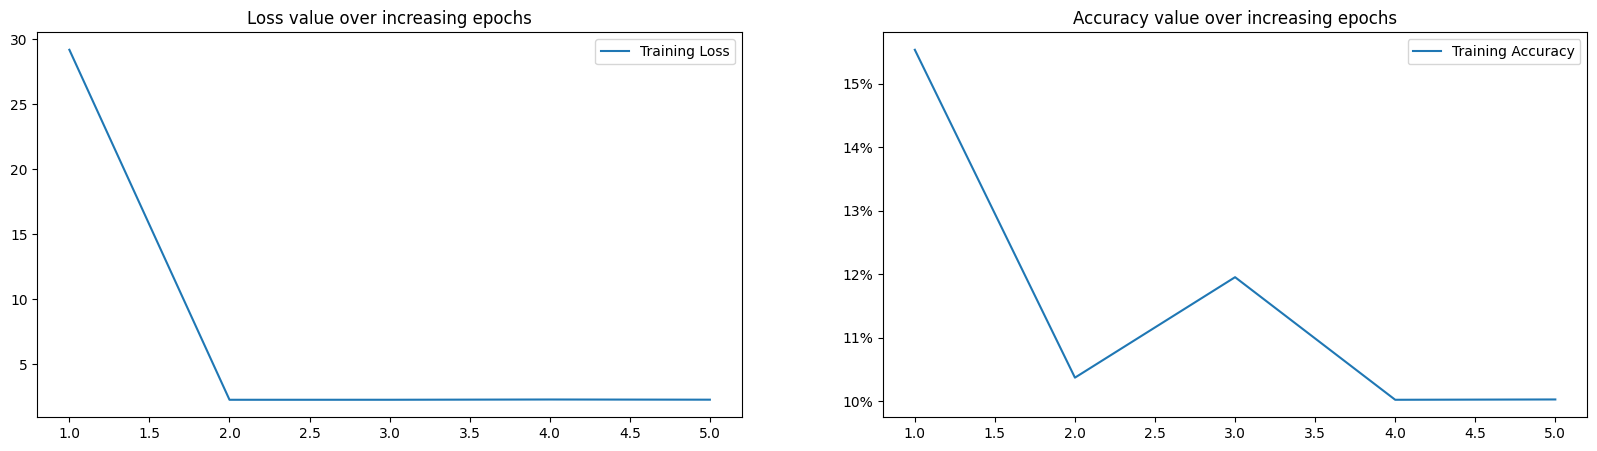

In [10]:
#完整代码
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = './data/FMNIST' #指定下载数据集的路径
# 下载FMNIST数据集
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # 使用`model(x)`前向传播计算模型参数的梯度'model.parameters()'
    batch_loss.backward()
    # 新权重 = f(旧权重, 旧权重梯度)
    # "f" 是优化器optimizer
    optimizer.step()
    # 清空梯度，防止梯度累积影响下一次权重调整
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    # 计算每个行中最大值的位置是否与真实值相符
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

从返回的结果图表我们看到，这个模型预测图像的准确度在12%左右，并且损失值在第5轮训练之后已经不在下降，意味着我们再增加训练轮数也无法再提高模型的准确度，这就需要我们理解所使用的超参数是如何影响我们神经网络的准确性的。

### 12.1.3 缩放数据(Scaling)对模型准确度的影响

对数据集进行缩放是确保变量被限制在一个有限范围内的过程。在本节中，我们将通过将每个输入值除以数据集中可能的最大值，将独立变量的值限制在0和1之间。我们的数据集是灰阶图片，它的输入值为0-255，最大值是255，对应于白色像素：

0
1
2
3
4


/tmp/ipykernel_30/2286579875.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


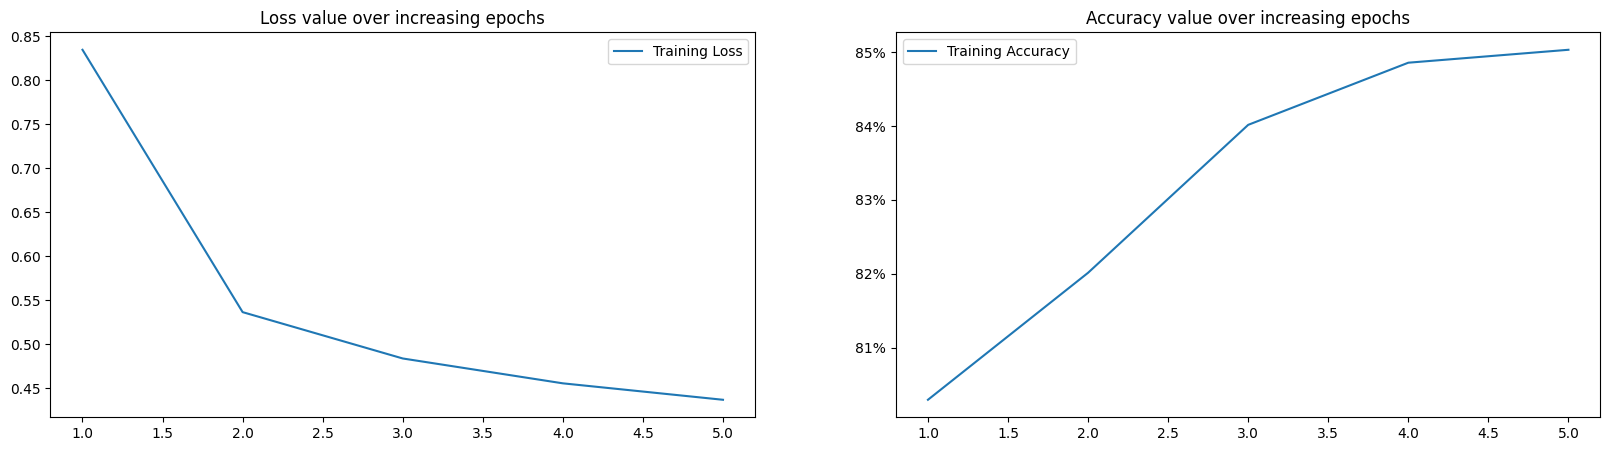

In [11]:
#完整代码
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = './data/FMNIST' #指定下载数据集的路径
# 下载FMNIST数据集
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        #对输入图像进行归一化
        #对输入图像进行归一化
        #对输入图像进行归一化
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # 使用`model(x)`前向传播计算模型参数的梯度'model.parameters()'
    batch_loss.backward()
    # 新权重 = f(旧权重, 旧权重梯度)
    # "f" 是优化器optimizer
    optimizer.step()
    # 清空梯度，防止梯度累积影响下一次权重调整
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    # 计算每个行中最大值的位置是否与真实值相符
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

为什么对输入数据进行归一化，会对模型的准确度有如此大的提升呢？<br>
我们定义模型时，使用的激活函数是sigmoid，其公式如下：<br>
#### $sigmoid = \frac{1}{e^{-(input*weight)}}$

图1<br>
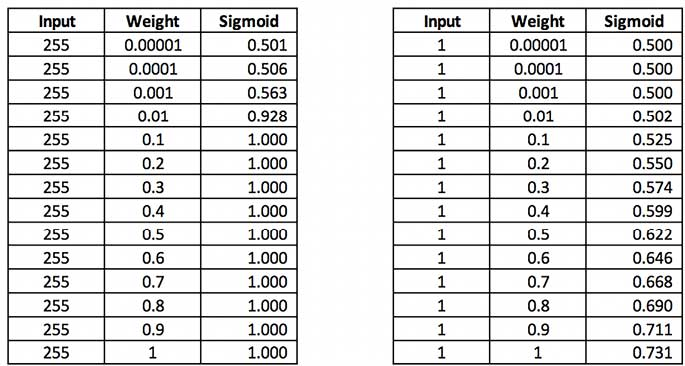

如左边的图表显示，当权重（weight）大于0.1时，sigmoid函数值不会随着权重值而变化。此外，当权重非常小的时候，sigmoid值只改变了一点点；要改变sigmoid函数值的唯一方法是通过改变权重的非常、非常小的量。<br>
然而在右侧的表格中，当输入值很小时，sigmoid值发生了相当大的变化。

这是因为一个很大的负数（由权重值乘以一个大数得到）的指数非常接近0，而当权重乘以一个缩放的输入时，指数值会发生变化，如右侧表格所示。

除了对输入数据进行归一化，会影响模型的准确度之外，模型的**批量尺寸**（batch size）、**优化器**（optimizer）、**批量归一化**（batch normalization）、**过拟合**（overfitting）都会影响模型预测的准确度。

## 12.2 深度神经网络的缺点

我们尝试将图片水平向右平移3个像素，然后再使用训练好的模型进行预测。

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Predicted Label: 6


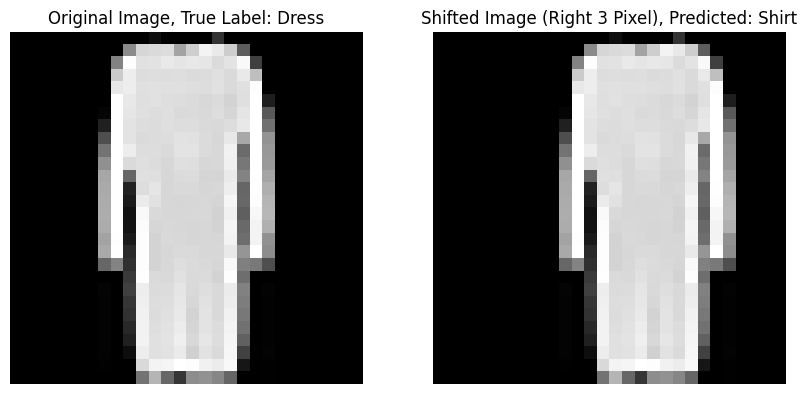

In [12]:
@torch.no_grad()
def predict_single_image(index, dataset, model):
    model.eval()
    
    # 获取数据和标签
    x, y = dataset[index]
    
    # 将图像转化为28*28的矩阵，然后水平向右移动图像
    x = x.view(28, 28)
    
    # 向右平移图片
    x_shifted = torch.zeros_like(x)  # 创建一个全零的张量
    x_shifted[:, 3:] = x[:, :-3]  # 将图片数据右移一列，左边补零

    # 将28*28的图像展平输入
    x_shifted_flattened = x_shifted.view(-1)  # [784]

    # 预测标签
    prediction = model(x_shifted_flattened.unsqueeze(0))  # 添加批次维度
    predicted_label = prediction.argmax(dim=1).item()
    print(f"Predicted Label: {predicted_label}")

    # 可视化原始图像
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(x.cpu().numpy(), cmap='gray')
    plt.title(f"Original Image, True Label: {fmnist.classes[y]}")
    plt.axis('off')

    # 可视化平移后的图像
    plt.subplot(1, 2, 2)
    plt.imshow(x_shifted.cpu().numpy(), cmap='gray')
    plt.title(f"Shifted Image (Right 3 Pixel), Predicted: {fmnist.classes[predicted_label]}")
    plt.axis('off')
    plt.show()
    

# 使用自定义的预测函数
print(fmnist.classes)
dataset = FMNISTDataset(tr_images, tr_targets)
predict_single_image(25, dataset, model)  # 修改索引选择其他图片

从结果我们可以看到，我们只是将图像水平向右平移了3个像素，但是图像的内容没有变化。然而模型却将图像的类别预测错误了。这是因为在模型训练时，所有训练和测试图像的内容都位于中心。这与我们平移之后测试（3像素）的图像不同，导致预测类别错误。<br>
现在我们已经了解了传统神经网络失败的场景，我们将学习卷积神经网络（CNN）如何帮助解决这个问题。但在我们做这件事之前，让我们先来看看CNN的基本构建块。

## 12.3 卷积神经网络

卷积神经网络（CNN）是计算机视觉领域应用最广泛的模型，它的主要优点在于其能够自动学习和提取图像特征，这使得它们在图像分类、目标检测和图像分割等任务中表现出色。CNN通过使用卷积层捕捉图像的**局部特征**，并利用池化层降低特征的空间维度，从而实现对图像的高效表示。此外，CNN的参数共享机制减少了模型的参数数量，降低了过拟合的风险，并提高了模型的泛化能力。这些特性使得CNN成为计算机视觉领域的首选模型。


卷积神经网络包含如下结构：
* 卷积
* 卷积核
* 步长与填充
* 池化

### 12.3.1 卷积

卷积本质上是使用卷积核对图像进行遍历。我们在数字图像处理9.7.2一节中有介绍1通道（黑白图像）卷积的计算过程，现在我们来讲解3通道（RGB彩色图片）卷积的计算过程。<br>
由于我们的图片有3个通道，所以我们的卷积核也同样要有3个通道，经过3通道的卷积核计算之后，会输出一个1通道的特征图，当我们需要输出64通道的特征图时，我们就需要64个卷积核，此外，如果有512个卷积核与中间层进行卷积操作，那么卷积后输出的形状为：512 x weight x height。

图2<br>
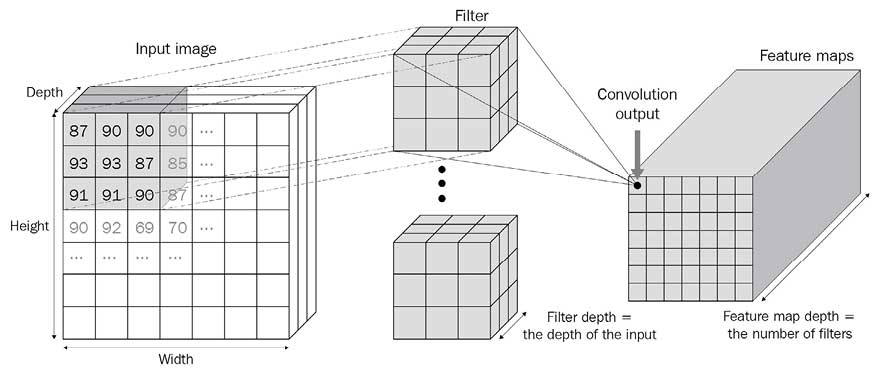

如上图所示，每一个卷积核与图像计算之后，会得到1通道的特征图，有多少个卷积核，就会输出多少个通道的特征图。

### 12.3.2 步长与填充

#### 步长<br>
步长（Stride）在卷积神经网络中指的是卷积核在输入数据上滑动时（向右、向下滑动）的间隔，它决定了卷积操作覆盖输入图像的步长和速度，从而影响输出特征图的输出形状。

#### 填充<br>
由于卷积操作会丢失边缘的信息，导致输出的特征图比输入的图像的尺寸更小，而填充（padding）是指在输入数据边缘填充额外的像素值（通常为零），以控制输出特征图的尺寸并保留边界信息。

### 12.3.3 池化

池化（Pooling）是卷积神经网络中的一种下采样操作，用于减少特征图的尺寸，保留关键信息，同时降低计算复杂度。常见的池化方法包括最大池化（Max Pooling）和平均池化（Average Pooling）。最大池化提取池化窗口内的最大值，突出显著特征；平均池化计算窗口内的平均值，保留整体特征分布。通过池化操作，卷积神经网络可以提高模型的平移不变性和抗噪能力，有助于提取更具鲁棒性的特征。

关于卷积部分，请参考数字图像处理 9.7.2一节：https://www.kaggle.com/code/jeanshendev/digital-image-processing

讲解完卷积、卷积核、步长与填充、池化之后，我们再来讲解卷积神经网络中另一个非常重要的部分，全连接层（也称为展平层flatten）。

图3<br>
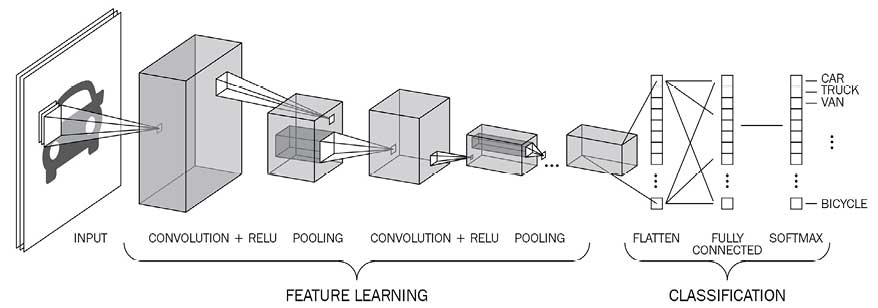

如图所示，我们之前的例子中，输入的图像为28*28像素的灰度图片（没有彩色通道），我们先将其展平（flatten）为784维（28*28=784）的向量，然后将其作为输入，传入卷积神经网络中，进行一系列的卷积、激活、池化计算，最后得到一个3维的特征图，最后我们将其展平，得到我们要预测的图片分类的数值，然后使用SOFTMAX函数将这些数值转化为对应的概率。

我们可以看到卷积神经网络模型的整体流程，其中我们通过多个卷积核进行卷积来传递图像，然后进行池化，在最终的池化层输出展平之前。这构成了前面图像的特征学习部分，我们正在将图像降低到更低的维度（展平的输出），同时保留所需的信息。<br>

卷积和池化操作构成了特征学习部分，卷积核滤器有助于从图像中提取相关特征，而池化有助于聚合信息，从而减少展平层的节点数量。

### 12.3.4 卷积和池化如何帮助提取局部特征

当我们执行池化操作时，我们可以将操作的输出视为一个区域的抽象。这种现象在图像平移时特别有用。想象一下，如果一个图像向左平移了1个像素。一旦我们对它执行卷积、激活和池化，我们将减少图像的维度（由于池化），这意味着较少的像素存储了原始图像的大部分信息。此外，鉴于池化存储了一个区域的信息，即使原始图像平移了1个单位，池化图像中的一个像素内的信息也不会变化。这是因为该区域的最大值可能会在池化图像中被捕获。

卷积和池化也可以帮助我们理解局部特征。让我们想象一下，我们在一张100x100形状的图像上执行两次卷积+池化操作。如果卷积操作使用了填充，那么两次卷积池化操作结束后的输出形状是25x25。现在，25x25输出中的每个单元对应于原始图像中更大的4x4部分。因此，由于卷积和池化操作，结果图像中的每个单元包含了原始图像中一个区域的关键信息。

现在我们已经了解了卷积神经网络的核心组件，让我们将应用到图片分类中，看看它们是如何工作的。

## 12.4 使用卷积神经网络进行图像分类

### 12.4.1 导入相应的库

In [13]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data_folder = '~/data/FMNIST' # This can be any directory you
# want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder,download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

### 12.4.2 定义数据集对象，数据集对象必须包含__init__, __getitem__, 和 __len__方法

In [14]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

### 12.4.3 定义卷积神经网络模型的结构

In [15]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3200, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

### 12.4.4 使用summary模块查看模型的结构

In [16]:
!pip install torchsummary 
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

100%|██████████| 26421880/26421880 [00:00<00:00, 111671327.44it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4279561.74it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 57427834.86it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9053365.62it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw

Note: you may need to restart the kernel to use updated packages.
0
1
2
3
4


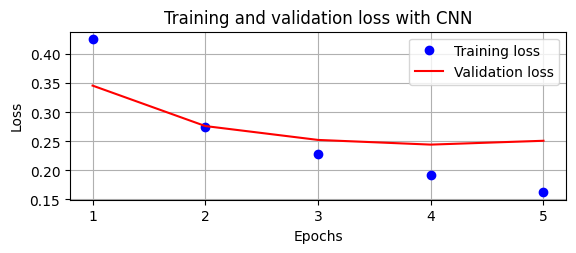

/tmp/ipykernel_30/2796712095.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


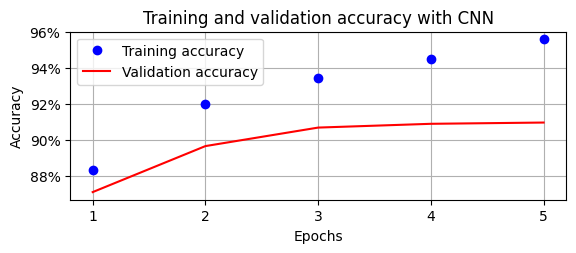

In [17]:
#完整代码
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

trn_dl, val_dl = get_data()
#model_cnn, loss_fn, optimizer = get_model()

%pip install torch_summary
from torchsummary import summary
model_cnn, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_cnn, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_cnn)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_cnn)
        validation_loss = val_loss(x, y, model_cnn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Predicted Label: 8


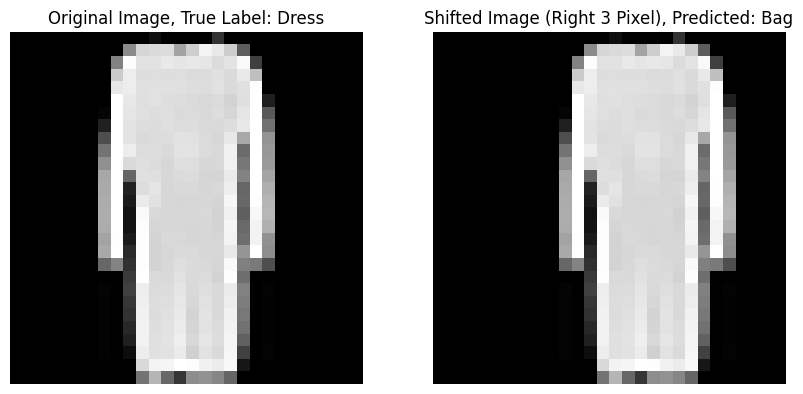

In [18]:
@torch.no_grad()
def predict_single_image(index, dataset, model):
    model.eval()
    
    # 获取数据和标签
    x, y = dataset[index]
    
    # 将图像转化为28*28的矩阵，然后水平向右移动图像
    x = x.view(28, 28)
    
    # 向右平移图片
    x_shifted = torch.zeros_like(x)  # 创建一个全零的张量
    x_shifted[:, 3:] = x[:, :-3]  # 将图片数据右移一列，左边补零

    # 将28*28的图像展平输入
    x_shifted_flattened = x_shifted.view(-1, 1, 28, 28)  # [784]

    # 预测标签
    #prediction = model(x_shifted_flattened.unsqueeze(0))  # 添加批次维度
    prediction = model(x_shifted_flattened)  # 添加批次维度
    predicted_label = prediction.argmax(dim=1).item()
    print(f"Predicted Label: {predicted_label}")

    # 可视化原始图像
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(x.cpu().numpy(), cmap='gray')
    plt.title(f"Original Image, True Label: {fmnist.classes[y]}")
    plt.axis('off')

    # 可视化平移后的图像
    plt.subplot(1, 2, 2)
    plt.imshow(x_shifted.cpu().numpy(), cmap='gray')
    plt.title(f"Shifted Image (Right 3 Pixel), Predicted: {fmnist.classes[predicted_label]}")
    plt.axis('off')
    plt.show()
    

# 使用自定义的预测函数
print(fmnist.classes)
dataset = FMNISTDataset(tr_images, tr_targets)
predict_single_image(25, dataset, model_cnn)  # 修改索引选择其他图片

## 12.5 迁移训练

我们知道随着训练数据集中图像数量的增加，模型的分类准确度也在不断提高，也就是包含8000张图像的训练数据集在验证数据集上的准确度比包含1000张图像的训练数据集要高。但是，我们并不总是有成百上千的图像及其对应类别的真实标签来训练模型。这时，迁移学习就派上了用场。<br>
迁移学习是一种技术，通过将模型在通用数据集上的学习成果迁移到特定目标任务的数据集上，从而提升模型的表现。通常，执行迁移学习时，预训练模型是在大量通用图像（通常包含数百万张）上训练而成的，这些图像并非目标任务的数据集。随后，这些预训练模型会根据目标数据集的特点进行微调，使其更适用于特定任务。迁移学习的核心特点是能够利用已有的大规模通用知识，加速模型训练并在小样本数据集上实现优异表现。上。

### 12.5.1 什么是迁移训练

迁移学习是利用从一个图像分类任务中获得的特征（weight）来解决另一个相似的图像分类任务。<br>
设想有一个训练好的图像分类模型，这个模型使用数百万图片进行训练，能对上千个对象进行分类别（不仅仅是猫和狗。模型。模权重（weight）已经拟合了数据集中图像中的各种形状、颜色上激活。我们利用这些训练好的权重（weight）被重用来在一组新的图像上学习特征。在学习了特征之后，它们可以被连接到隐藏层，然后再连接到最终层之前，以适应新数据。

设想这样一种情况：我们需要处理道路相关的图像，试图根据图像中包含的对象对它们进行分类。如果从头开始构建模型可能效果并不理想，因为我们的图像数量可能不足以学习数据集中的各种变化。在这种情况下，一个预训练模型就派上用场了。它在训练过程中已经学习了很多与交通相关的类别，比如汽车、道路、树木和人类。因此，利用这个已经训练好的模型将使得训练更快、更准确，因为模型已经知道了通用的形状，现在只需要将它们适配到特定的新数据集上。

要进行迁移训练，我们需要进行如下步骤：<br>
1. 使用同样的参数（使用与预训练模型同样的平均值mean和标准差standard deviation）对输入的图像进行归一化。<br>
2. 获取预训练模型的架构。获取预训练模型的训练后的权重。<br>
3. 丢弃预训练模型的最后几层，接入我们针对特定数据集微调最后几层。<br>
4. 将截断的预训练模型连接到一个新初始化的层（或层），其中权重是随机初始化的。确保最后一层的输出与我们想要预测的类别/输出一样多的神经元。<br>
5. 确保预训练模型的权重不可训练（冻结预训练模型的权重），只训练我们接入的层的权重。<br>
6. 训练模型，更新我们新接入层的权重。<br>

我们使用VGG16（Visual Geometry Group）预训练模型来演示，迁移训练：<br>
VGG代表牛津大学的视觉几何组。16表示模型中的层数。VGG16模型在2014年的ImageNet竞赛中获得亚军。VGG16因其简洁性以及在视觉社区中对多种任务的广泛应用而备受青睐。

VGG模型的结构如下图所示：

图4<br>
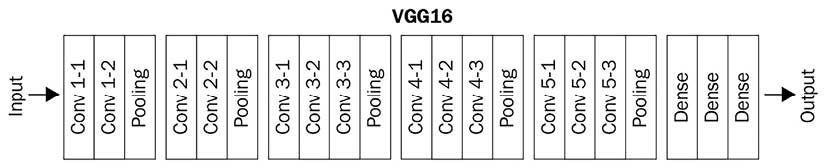

我们可以使用如下代码获取VGG16模型，并查看VGG16模型的总结：

In [19]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#获取VGG16模型，并绑定到设备
model = models.vgg16(pretrained=True).to(device)
#查看VGG16模型的总结
summary(model, (3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG16模型中有大约1.38亿个参数（其中约1.22亿个参数位于网络末尾的线性层——1020万 + 160万 + 400万个参数），包括13层卷积和/或池化层，卷积核数量逐渐增加，以及3层线性层。<br>
VGG16模型中有三个主要的子模块：特征提取、平均池化（avgpool）和分类器。通常，我们会冻结特征提取和平均池化模块。删除分类器模块，并在其位置创建一个新的模块，以预测与我们数据集相对应的所需类别数量（原模型有1,000个类别）。

## 12.6 使用VGG16预训练模型进行图像分类

### 12.6.1 导入相关的库

In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

### 12.6.2 导入数据集<br>
我们使用的是kaggle上的tongpython/cat-and-dog数据集，可以在数据集页面搜索“tongpython/cat-and-dog”，并将数据集加入书签，然后notebook中add input添加数据集，如果是本地环境使用kaggle数据集：可以参考：https://cv.kedaya.online/article/using-kaggle-datasets-locally/

In [21]:
train_data_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
test_data_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

### 12.6.3 定义dataset类，我们只使用数据集中的前500张图片进行训练

In [22]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500][:500] + dogs
        self.normalize = transforms.Normalize(mean=[0.485, 
                 0.456, 0.406],std=[0.229, 0.224,  0.225])
        from random import shuffle, seed; seed(10); 
        shuffle(self.fpaths)
        #使用“/”分割文件路径，[-1]为保留最后一部分，即文件名部分
        #startswith('dog')，如果以“dog”开头，在返回true，即返回1
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath \
                                                           in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return (
            im.float().to(device), 
            torch.tensor([target]).float().to(device)
        )

### 12.6.4 获取图片标签，其中标签1为狗，标签0为猫

In [23]:
data = CatsDogs(train_data_dir)
print(train_data_dir)
print(len(data))
im, label = data[300]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

/kaggle/input/cat-and-dog/test_set/test_set
0


IndexError: list index out of range

### 12.6.5 下载VGG16预训练模型即权重，然后冻结特征模块，使用平均池化（avgpool）和分类器（classifier）模块进行训练

In [ ]:
#下载VGG16模型
def get_model():
    model = models.vgg16(pretrained=True)
    
    #冻结参数
    for param in model.parameters():
        param.requires_grad = False

    #将模型的输出改为1，即预测1为狗，0为猫
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    #定义新的分类器
    model.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())

    #定义损失函数和优化器，使用二分类损失熵函数和Adam优化器
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
    return model.to(device), loss_fn, optimizer

#打印模型总结
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, (3,224,224))

### 12.6.6 训练模型

In [ ]:
#训练模型
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

#定义函数，计算模型准确度
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

#定义函数获取训练数据
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
                                          drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

#训练模型
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

#对训练的准确度进行可视化
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', 
         label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', 
         label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

验证模型

In [ ]:
data = CatsDogs(test_data_dir)
im, label = data[10]
#10猫
#90狗

import matplotlib.pyplot as plt
import cv2
import torch

# 定义一个函数，用于预测单张图片
def predict_image(im, model):
    # 加载图片
    image_tensor = (im / 255.0).clone().detach().unsqueeze(0)  # 转换为张量
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    image_tensor = normalize(image_tensor).to(device)  # 归一化并转移到设备

    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prediction = (output > 0.5).float()  # 阈值为0.5，1为狗，0为猫

    # 显示图片和预测结果
    #plt.imshow(im)
    img_label = "IMG_label: Dog" if label.item() == 1 else "IMG_label: Cat"
    plt.title(f"{img_label}, "+("Prediction: Dog" if prediction.item() == 1 else "Prediction: Cat"))
    plt.imshow(im.permute(1,2,0).cpu())
    plt.axis("off")
    plt.show()

# 加载训练好的模型
model, _, _ = get_model()

# 选择一张图片进行验证

predict_image(im, model)


根据结果我们可以看到，即便只有500张图片进行训练，模型的准确度也达到将近99%。

In [ ]:
#完整代码
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

train_data_dir = '/kaggle/input/cat-and-dog/test_set/test_set'
test_data_dir = '/kaggle/input/cat-and-dog/training_set/training_set'

class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500][:500] + dogs
        self.normalize = transforms.Normalize(mean=[0.485, 
                 0.456, 0.406],std=[0.229, 0.224,  0.225])
        from random import shuffle, seed; seed(10); 
        shuffle(self.fpaths)
        #使用“/”分割文件路径，[-1]为保留最后一部分，即文件名部分
        #startswith('dog')，如果以“dog”开头，在返回true，即返回1
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath \
                                                           in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return (
            im.float().to(device), 
            torch.tensor([target]).float().to(device)
        )

data = CatsDogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

#下载VGG16模型
def get_model():
    model = models.vgg16(pretrained=True)
    
    #冻结参数
    for param in model.parameters():
        param.requires_grad = False

    #将模型的输出改为1，即预测1为狗，0为猫
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    #定义新的分类器
    model.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())

    #定义损失函数和优化器，使用二分类损失熵函数和Adam优化器
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
    return model.to(device), loss_fn, optimizer

#打印模型总结
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, (3,224,224))

#训练模型
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

#定义函数，计算模型准确度
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

#定义函数获取训练数据
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
                                          drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

#训练模型
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

#对训练的准确度进行可视化
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', 
         label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', 
         label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()